In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from circuit_sim import circuit_sim

lic = 3.5 * 60.8
ic_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
vb = 0.50e-3
ibf_list = [0.4, 0.5]
bc_list = [1, 2]
tot_combi = len(ic_list) * len(ibf_list) * len(bc_list)
indices = range(1, tot_combi + 1)

def calc_nominal_ic_uA(Ic_uA, L_pH):
    f_q = 2.06783385*(10**(-15))
    Ic_A = Ic_uA*10**(-6)
    L_H = L_pH*10**(-12)
    x = (L_H * Ic_A) / f_q
    result = (0.5263*x**6 -2.3279*x**5 + 3.4434*x**4 - 1.0023*x**3 - 2.5876*x**2 + 3.341*x)*Ic_A
    return result*10**6

def strParse(index, tot_combi):
    ibf_tag = 0 if index <= (tot_combi/2) else 1
    bc_tag = 0 if (index <= (tot_combi/4) or index > (tot_combi*3/4)) else 1
    ibf = ibf_list[ibf_tag]
    bc = bc_list[bc_tag]
    Ic = ic_list[(index % len(ic_list)) - 1]
    return ibf, bc, Ic

def run_simulation(i):
    ibf, bc, Ic = strParse(i, tot_combi)
    sim_con = circuit_sim("jtl_base.cir")
    sim_con.new_make_jtl2(Ic, lic, vb, ibf, bc)

    res_start = sim_con.get_switch_timing(["P(B1|X1|X1|X35)", "P(B2|X1|X1|X35)"])
    res_fin = sim_con.get_switch_timing(["P(B1|X1|X1|X5)", "P(B2|X1|X1|X5)"])

    diff1 = res_fin["time"].iloc[0] - res_start["time"].iloc[0]
    diff2 = res_fin["time"].iloc[1] - res_start["time"].iloc[1]
    base_diff = (diff1 + diff2) / 2
    per_squid = base_diff / 40  # ps per SQUID

    return {
        "index": i,
        "Ic_uA": Ic,
        "LIc_uA_pH": lic,
        "Vb_mV": vb * 1e3,
        "Ibfactor": ibf,
        "Betac": bc,
        "ps_per_SQUID": per_squid
    }

In [4]:
if __name__ == "__main__":
    results = []
    max_workers = 20
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(run_simulation, i): i for i in indices}
        for future in as_completed(futures):
            res = future.result()
            results.append(res)

    df = pd.DataFrame(results)
    df = df.sort_values(by="index").reset_index(drop=True)
    print(df)

    index  Ic_uA  LIc_uA_pH  Vb_mV  Ibfactor  Betac  ps_per_SQUID
0       1     10      212.8    0.5       0.4      1  5.075000e-12
1       2     20      212.8    0.5       0.4      1  5.077500e-12
2       3     30      212.8    0.5       0.4      1  5.075000e-12
3       4     40      212.8    0.5       0.4      1  5.075000e-12
4       5     50      212.8    0.5       0.4      1  5.075000e-12
5       6     60      212.8    0.5       0.4      1  5.077500e-12
6       7     70      212.8    0.5       0.4      1  5.075000e-12
7       8     80      212.8    0.5       0.4      1  5.077500e-12
8       9     90      212.8    0.5       0.4      1  5.077500e-12
9      10    100      212.8    0.5       0.4      1  5.076250e-12
10     11     10      212.8    0.5       0.4      2  3.750000e-12
11     12     20      212.8    0.5       0.4      2  3.751250e-12
12     13     30      212.8    0.5       0.4      2  3.750000e-12
13     14     40      212.8    0.5       0.4      2  3.750000e-12
14     15 

/tmp/ipykernel_2379092/2819600895.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


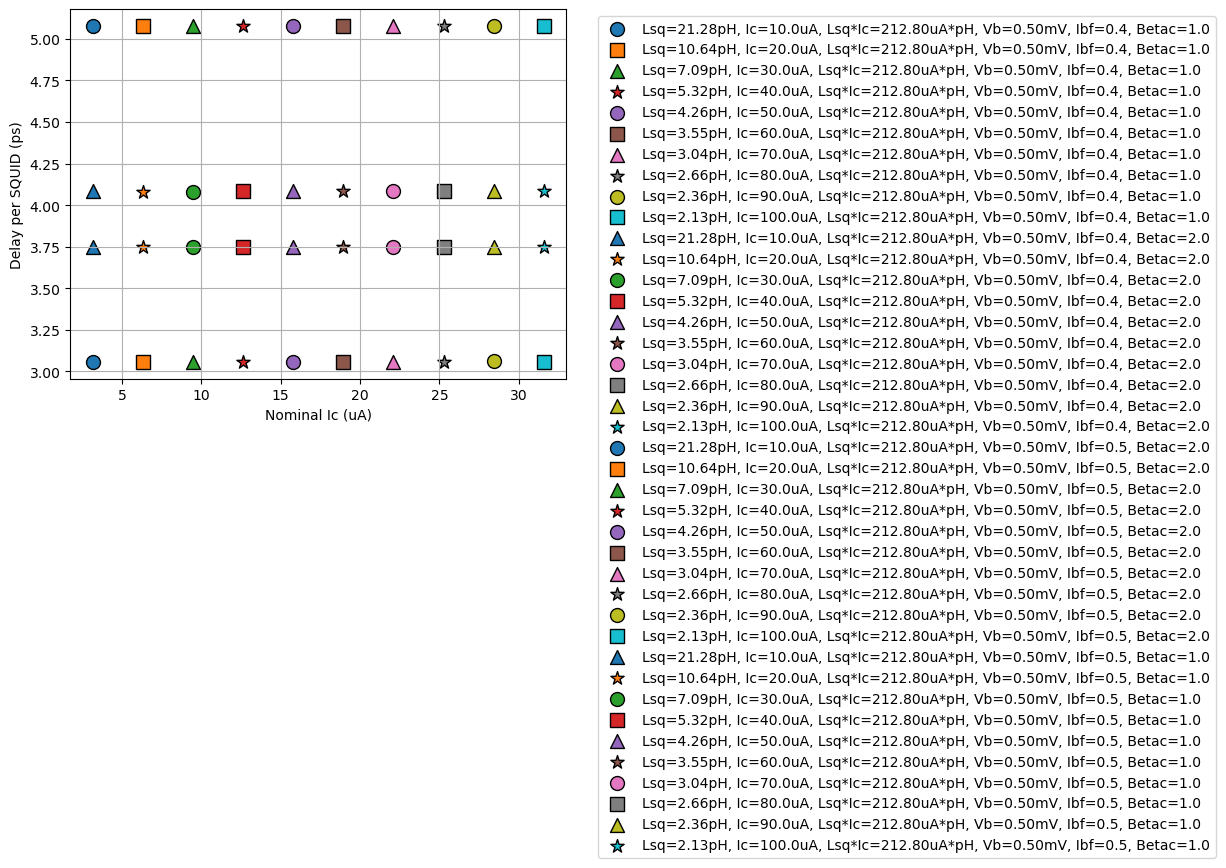

In [5]:
import matplotlib.pyplot as plt

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# marker_styles = ['o', 's', '^', 'v', '<', '>', 'x', '+', '*', 'D']
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

plt.figure()
for i in range(len(df["index"])):
    marker_map = i % len(marker_styles)
    # color_map = int(i / int(tot_combi/len(ic_list)))
    Ic = df["Ic_uA"].iloc[i]
    LIc = df["LIc_uA_pH"].iloc[i]
    Icn = calc_nominal_ic_uA(Ic, LIc/Ic)
    Vb = df["Vb_mV"].iloc[i]
    Ibfactor = df["Ibfactor"].iloc[i]
    Betac = df["Betac"].iloc[i]
    delay = df["ps_per_SQUID"].iloc[i]
    label = f"Lsq={LIc/Ic:.2f}pH, Ic={Ic:.1f}uA, Lsq*Ic={LIc:.2f}uA*pH, Vb={Vb:.2f}mV, Ibf={Ibfactor}, Betac={Betac:.1f}"
    if Vb == 0.5:
        plt.scatter(Icn, delay*1e12, marker=marker_styles[marker_map], label=label, s=100, edgecolors='black')
        # plt.scatter(Icn, delay*1e12, marker=marker_styles[marker_map], label=label, s=100, edgecolors='black', color=colors[color_map])
# plt.xlim(15, 23)
# plt.ylim(0, 6)
plt.xlabel("Nominal Ic (uA)")
plt.ylabel("Delay per SQUID (ps)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()  

/tmp/ipykernel_2379092/3525271059.py:63: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(Icn, row["Std"]*1e12, label=name,


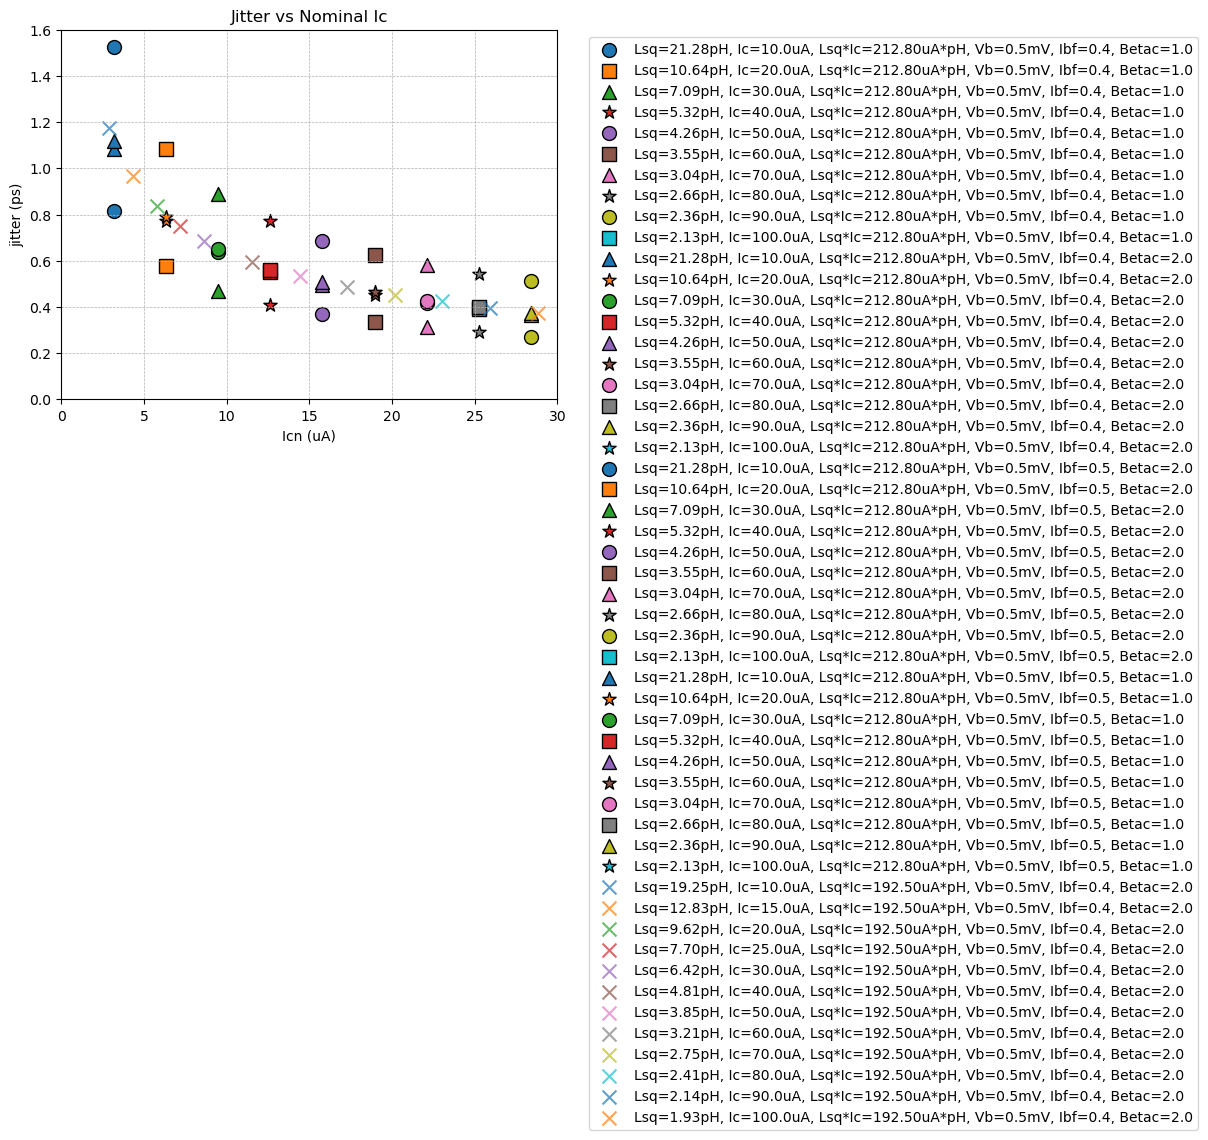

In [6]:
# (2)
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

plt.rcParams['font.family'] = ''
open("jitter.csv", "w").close()
xy_data = pd.DataFrame(columns=["Name", "Icn", "Std"])
for i in indices:
    ibf, bc, Ic = strParse(i, tot_combi)
    diff_file = f"jitter/diff_{i}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)
    std_per_squid = math.sqrt(std*std/40)
    Icn = calc_nominal_ic_uA(Ic, lic/Ic)
    name = f"Lsq={lic/Ic:.2f}pH, Ic={Ic:.1f}uA, Lsq*Ic={lic:.2f}uA*pH, Vb={vb*1e3:.1f}mV, Ibf={ibf}, Betac={bc:.1f}"
    if vb == 0.5e-3:
        xy_data = pd.concat([xy_data, pd.DataFrame([[name, Icn, std_per_squid, lic, Ic, vb, ibf, bc]], columns=["Name", "Icn", "Std", "LIc", "Ic", "Vb", "Ibf", "Betac"])], ignore_index=True)

    with open("jitter.csv", "a") as f:
        f.write(f"{lic},{Ic},{vb},{ibf},{bc},0,{std_per_squid}\n")
        
    # fig = plt.figure()
    # plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, 'r', linewidth=2, label="Fitted Normal Distribution")
    # plt.xlabel("Jitter Value")
    # plt.ylabel("Density")
    # plt.title("Fractuation of Propagation Time")
    # plt.legend()
    # plt.savefig(f"jitter/jitter_{i}.png")
    # # plt.show()
    # plt.close()

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig = plt.figure()
for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    # color_map = int(idx / int(len(xy_data)/len(lic_list)))
    plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],
                marker=marker_styles[marker_map],
                s=100,
                # color = colors[color_map],
                edgecolors='black',
                alpha=1.0,
                )

past_file = "jitter_rev.csv"
past_data = pd.read_csv(past_file, names=["LIc", "Ic", "Mu", "Std"])
for idx, row in past_data.iterrows():
    lic = row["LIc"]
    Ic = row["Ic"]
    name = f"Lsq={lic/Ic:.2f}pH, Ic={Ic:.1f}uA, Lsq*Ic={lic:.2f}uA*pH, Vb=0.5mV, Ibf=0.4, Betac=2.0"
    # name = f"{lic/Ic:.1f}pH,{Ic}uA,0.5mV,Ibf=0.4,Bc=2"
    Icn = calc_nominal_ic_uA(Ic, lic/Ic)
    if Ic >= 10:
        plt.scatter(Icn, row["Std"]*1e12, label=name,
                    marker='x',
                    s=100,
                    edgecolors='black',
                    alpha=0.7)
    
plt.xlim(0, 30)
plt.ylim(0, 1.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter vs Nominal Ic')
plt.xlabel('Icn (uA)')
plt.ylabel('jitter (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()
plt.close()

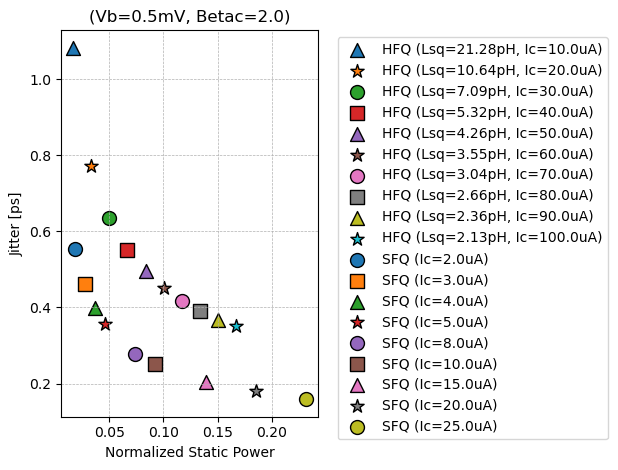

In [41]:
fig = plt.figure()
# marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'x', '+', '<', '>']
marker_styles = ['o', 's', '^', '*']

vb = 0.50e-3
ibf = 0.4
betac = 2.0
base_ic_uA = 108
norm_d_factor = 0.7/(ibf/2)
noem_s_factor = 0.7/ibf

for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    if row["Betac"] == betac and row["Ibf"] == ibf:
        name = f"HFQ (Lsq={row['LIc']/row['Ic']:.2f}pH, Ic={row['Ic']:.1f}uA)"
        plt.scatter(((row["Icn"]/noem_s_factor)/base_ic_uA), row["Std"]*1e12, label=name,
                    marker=marker_styles[marker_map],
                    s=100,
                    edgecolors='black',
                    alpha=1.0,
                    )

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
sfq_file = "jitter_sfq_lv.csv"
sfq_data = pd.read_csv(sfq_file, names=["Ic", "Vb", "Betac", "Std"])
for idx, row in sfq_data.iterrows():
    marker_map = idx % len(marker_styles)
    if row["Vb"] == 0.50e-3:
        if row["Ic"] < 30:
            name = f"SFQ (Ic={row['Ic']:.1f}uA)"
            plt.scatter(row["Ic"]/base_ic_uA, row["Std"]*1e12, label=name,
                        marker=marker_styles[marker_map],
                        s=100,
                        edgecolors='black',
                        alpha=1.0,
                        )
        
# plt.xlim(18.75, 20.5)
# plt.ylim(0, 0.8)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Normalized Static Power')
plt.ylabel('Jitter [ps]')
plt.title(f"(Vb={vb*1e3:.1f}mV, Betac={betac:.1f})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

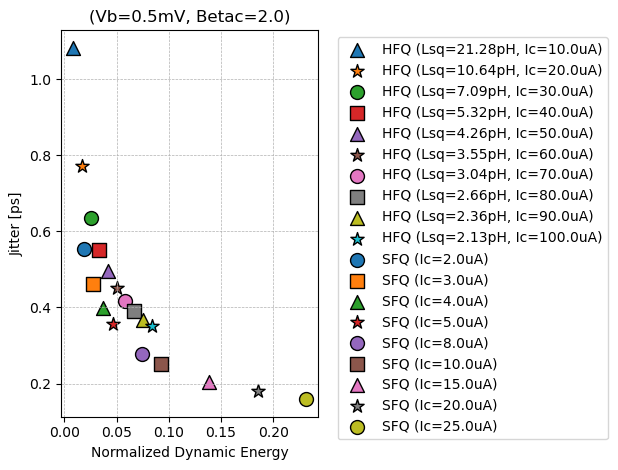

In [42]:
fig = plt.figure()
# marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'x', '+', '<', '>']
marker_styles = ['o', 's', '^', '*']

vb = 0.50e-3
ibf = 0.4
betac = 2.0
base_ic_uA = 108
norm_d_factor = 0.7/(ibf/2)
noem_s_factor = 0.7/ibf

for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    if row["Betac"] == betac and row["Ibf"] == ibf:
        name = f"HFQ (Lsq={row['LIc']/row['Ic']:.2f}pH, Ic={row['Ic']:.1f}uA)"
        plt.scatter(((row["Icn"]/norm_d_factor)/base_ic_uA), row["Std"]*1e12, label=name,
                    marker=marker_styles[marker_map],
                    s=100,
                    edgecolors='black',
                    alpha=1.0,
                    )

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
sfq_file = "jitter_sfq_lv.csv"
sfq_data = pd.read_csv(sfq_file, names=["Ic", "Vb", "Betac", "Std"])
for idx, row in sfq_data.iterrows():
    marker_map = idx % len(marker_styles)
    if row["Vb"] == 0.50e-3:
        if row["Ic"] < 30:
            name = f"SFQ (Ic={row['Ic']:.1f}uA)"
            plt.scatter(row["Ic"]/base_ic_uA, row["Std"]*1e12, label=name,
                        marker=marker_styles[marker_map],
                        s=100,
                        edgecolors='black',
                        alpha=1.0,
                        )
        
# plt.xlim(18.75, 20.5)
# plt.ylim(0, 0.8)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Normalized Dynamic Energy')
plt.ylabel('Jitter [ps]')
plt.title(f"(Vb={vb*1e3:.1f}mV, Betac={betac:.1f})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()